<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/ai/ai-uis-student/raw/master/imgs/banner_IA.png"  width="1000px" height="250px">




# <center> **13. An extra application on Deep neuronal networks** </center>

From DNN lecture seen on previous class, try to approach this algorithms in other application: audio recognition. 

##  **Outline**
1. [**DL:Understanding audio settings**](#eje1)
2. [**DL:audio from raw analysis**](#eje2)
3. [**DL:audio from melspectrograms**](#eje3)

In [ ]:
#@title **Execute this cell**
#@markdown Please include your student id
import sys
import inspect

group_id = "IA1-20231-H1" #@param {type:"string"}
assignment_id = group_id +'.deep_learning'
student_id = "2218109" #@param {type:"string"}
"""
Put your student ID here

Example: student_id =  '2152145'
""" 

"\nPut your student ID here\n\nExample: student_id =  '2152145'\n"

In [ ]:
#@title **Execute this cell**
#@markdown **UTILS**
#@markdown Please dont modify any line in this cell

import os
import json
import requests
from collections import namedtuple


Config = namedtuple('Config', ['server_name'])
config = Config(server_name='https://bivlabgrader.azurewebsites.net/api')


def check_solution_and_evaluate(assignment_id: str, student_func_str: str):

    # Set the endpoint and payload.
    payload = {
        'func_str': student_func_str,
        'assignment_id': assignment_id,
        'student_id': student_id
    }
    endpoint_url = config.server_name + '/CheckAndEvaluateSolution'
    # print(endpoint_url)

    # Make request to server with the data coming from the notebook.
    r = requests.post(endpoint_url, params=payload)
    pprint_json_response(r.json())
    return r


def pprint_json_response(response, indent=0):
    """Pretty print the response."""
    for key, value in response.items():
        print('\t' * indent + str(key.capitalize()))

        # If dictionary, do a recurrent call.
        if isinstance(value, dict):
            pprint_json_response(value, indent + 1)
        else:
            # Enumerate elements if list.
            if isinstance(value, list):
                if len(value) == 1:
                    print('\t' * (indent + 1) + str(value[0]))
                else:
                    for i, e in enumerate(value, start=1):
                        print('\t' * (indent + 1) + f'{i}. {e}')
            else:
                print('\t' * (indent + 1) + str(value))

In [ ]:
#@title **MONTAR EL DRIVE** { display-mode: "form" }
import os
from google.colab import drive

path_ai = "course-AI/ai-uis-student" #@param {type:"string"}
path = "/content/drive/My Drive/" + path_ai
drive.mount('/content/drive')
os.chdir(path)
print(os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/course-AI/ai-uis-student


In [ ]:
#@title 2. LOAD LIB { display-mode: "form" }
#@markdown Here is important to change to GPU  
import os
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#!pip install librosa

2.7.0


A typical library to read and rpocess audio is `librosa`. We firstly install library and then we can start to work. 

`!pip install librosa`

# **1. DL:Understanding audio settings** <a name="eje1"></a>

<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/ai/ai-uis-student/raw/master/imgs/speech.jpeg" alt="Drawing" style="width:1700px;">

## **1.1 Free Spoken Digit Dataset (FSDD): The speech MNIST**

A simple audio/speech dataset consisting of recordings of spoken digits in wav files at 8kHz. The recordings are trimmed so that they have near minimal silence at the beginnings and ends [Source](https://github.com/Jakobovski/free-spoken-digit-dataset)

### Dataset description

- 4 speakers
- 2.000 recordings (50 of each digit per speaker)
- English pronunciations

An example of the dataset: `{digitLabel}_{speakerName}_{index}.wav` Example: `7_jackson_32.wav`

A typical library to read and rpocess audio is `librosa`. We firstly install library and then we can start to work`

In [ ]:
#@title **code** reproduce an audio example
file_name = "7_jackson_40.wav" #@param {type:"string"}

import IPython.display as ipd
ipd.Audio('data/fsdd/'+file_name)

sr: 8000
wav shape: (3532,)


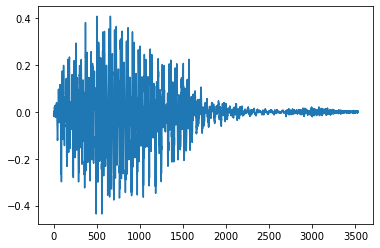

In [ ]:
#@title **code** Working with librosa
import librosa
wav, sr = librosa.load('data/fsdd/8_jackson_40.wav', sr=None)
print( 'sr:', sr)
print( 'wav shape:', wav.shape)

plt.plot(wav);

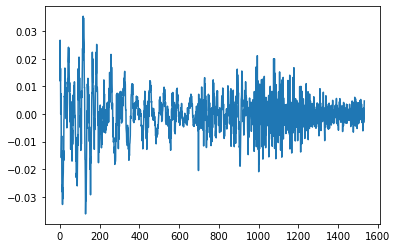

In [ ]:
#@title **code** To see more specific interval of signal
plt.plot(wav[2000:5000])

## **To load audio data**

- Read the FSDD audio dataset, using `librosa` library
  - Built the $\mathbf{X}$ $\in$ $\mathbb{R}^{n \times m}$ matrix. The $n$ rows are the examples (20000) and $m$ colums is the dimension of each file. 
  - Built the $\mathbf{y} \in \mathbb{R}^{n}$ corresponding to classes labels. 
    
    
**Pay attention that all files dont have the same dimension.** Then, we add zeros to obtain files with same size. This process is named `padding`    
- For so, you can use next function.

In [ ]:
#@title **code** Padding function
def func_padding(wav, pad_size=2000):
    if wav.shape[0] > pad_size:
        return wav[0: pad_size]
    else:
        return np.hstack((wav, np.zeros(pad_size - wav.shape[0])))

In [ ]:
#@title **code** Read data
#@markdown Consider only take three different values.
def get_XyData(DATA_DIR = 'data/fsdd/', pad_size=200):

  X =[]
  y =[]
  
  for fname in os.listdir(DATA_DIR):
    struct = fname.split('_')
    digit = struct[0]
    if (digit is '0') or (digit is '1'):
      wav, sr = librosa.load(DATA_DIR + fname)
      padded = func_padding(wav, pad_size)
      #padded = padded.reshape(padded.shape[0],1)
      X.append(padded)
      y.append(digit)   

  return np.vstack(X), np.array(y)

In [ ]:
#@title **code** To obtain all data
X, y = get_XyData(DATA_DIR = 'data/fsdd/')

print( 'X:', X.shape)
print( 'y:', y.shape)


X: (400, 200)
y: (400,)


# **2. DL:audio from raw analysis** <a name="eje2"></a>

- Modify `get_XyData` to only classify two classes (read all classes can take a lot of time)
- Split data on training (60% ) and test (40%).

In [ ]:
#@title **code** Train - Test split
from sklearn.model_selection import train_test_split
test_size = 0.4
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
print(X_train.shape, X_test.shape)
print(X_train[0].shape)
print(y_train.shape, y_test.shape)

(240, 200) (160, 200)
(200,)
(240,) (160,)


In [ ]:
#@title **code** THE ONE-HOT-ENCODING!
y_train_ohe = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test_ohe = tf.keras.utils.to_categorical(y_test, num_classes=2)
print(y_train_ohe.shape, y_test_ohe.shape)

(240, 2) (160, 2)


<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/ai/ai-2-uis-student/-/raw/master/imgs/icon1.png" width="200">

- Built a DNN with the following configuration: 
    - the input is the `x[0]` dimension
    - A hidden layer of 128 neurons. 
    - the output is `sigmoid` (`softmax` is for multiclassification problems) layer with `n` outputs, corresponding to classes
    - print the summary

In [ ]:
#@title **code professor** DNN model
model = tf.keras.Sequential([
    tf.keras.layers.Flatten( input_shape= X_train[0].shape),
    tf.keras.layers.Dense(128, activation='relu'),                             
    tf.keras.layers.Dense(2, activation='sigmoid')     #softmax for multiple classes               
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 200)               0         
                                                                 
 dense (Dense)               (None, 128)               25728     
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 25,986
Trainable params: 25,986
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#@title **code** To compile and fit the model
#@markdown fit the model wit a  `batch_size=10` and `epochs=15`
model.compile(optimizer=tf.keras.optimizers.SGD(), 
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.fit(X_train, y_train_ohe, epochs=5)

Epoch 1/5
8/8 [==============================] - 1s 3ms/step - loss: 0.6926 - accuracy: 0.5708
Epoch 2/5
8/8 [==============================] - 0s 3ms/step - loss: 0.6926 - accuracy: 0.5542
Epoch 3/5
8/8 [==============================] - 0s 3ms/step - loss: 0.6926 - accuracy: 0.5583
Epoch 4/5
8/8 [==============================] - 0s 2ms/step - loss: 0.6925 - accuracy: 0.5583
Epoch 5/5
8/8 [==============================] - 0s 3ms/step - loss: 0.6925 - accuracy: 0.5583


In [ ]:
#@title **code** To test the model
test_loss, test_acc = model.evaluate(X_test, y_test_ohe)

print( 'Test accuracy:', test_acc, " test_loss: ", test_loss)

5/5 [==============================] - 0s 2ms/step - loss: 0.6929 - accuracy: 0.5000
Test accuracy: 0.5  test_loss:  0.692949652671814


Compile the model, using the next configuration

Epoch 1/10
6/6 [==============================] - 1s 102ms/step - loss: 0.6926 - accuracy: 0.5292 - val_loss: 0.6929 - val_accuracy: 0.4875
Epoch 2/10
6/6 [==============================] - 0s 13ms/step - loss: 0.6925 - accuracy: 0.5500 - val_loss: 0.6929 - val_accuracy: 0.4875
Epoch 3/10
6/6 [==============================] - 0s 12ms/step - loss: 0.6925 - accuracy: 0.5417 - val_loss: 0.6929 - val_accuracy: 0.4812
Epoch 4/10
6/6 [==============================] - 0s 13ms/step - loss: 0.6925 - accuracy: 0.5458 - val_loss: 0.6929 - val_accuracy: 0.4750
Epoch 5/10
6/6 [==============================] - 0s 11ms/step - loss: 0.6925 - accuracy: 0.5458 - val_loss: 0.6930 - val_accuracy: 0.4812
Epoch 6/10
6/6 [==============================] - 0s 11ms/step - loss: 0.6925 - accuracy: 0.5375 - val_loss: 0.6930 - val_accuracy: 0.4938
Epoch 7/10
6/6 [==============================] - 0s 13ms/step - loss: 0.6924 - accuracy: 0.5417 - val_loss: 0.6930 - val_accuracy: 0.4875
Epoch 8/10
6/6 [==========

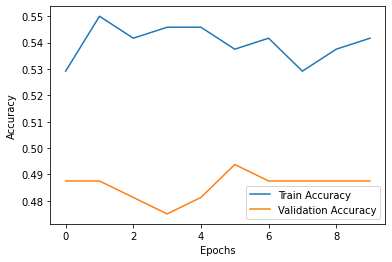

In [ ]:
#@title **code** other training evaluation
history = model.fit(X_train,
          y_train_ohe,
          epochs=10,
          batch_size=40,
          validation_data=(X_test, y_test_ohe))

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/ai/ai-2-uis-student/-/raw/master/imgs/icon1.png" width="200">

- what happened? ...

- Try with other DNN network more conected:
    - hidden layer of 10000
- Try with other DNN network **more deeply**:    
    - hidden layer of 1500
    - hidden layer of 500
    - hidden layer of 1500
- Try also changing padding parameter to obtaine samples with size: [5000, 20000]



In [ ]:
#@title **code professor** the model
model = tf.keras.Sequential([
    tf.keras.layers.Flatten( input_shape= (X_train[0].shape)),
    tf.keras.layers.Dense(5000, activation=tf.nn.relu),
    tf.keras.layers.Dense(2500, activation=tf.nn.relu),
    tf.keras.layers.Dense(1500, activation=tf.nn.relu),
    tf.keras.layers.Dense(500, activation=tf.nn.relu),
    tf.keras.layers.Dense(256, activation=tf.nn.relu),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(2, activation=tf.nn.softmax)
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5000)              1005000   
_________________________________________________________________
dense_3 (Dense)              (None, 2500)              12502500  
_________________________________________________________________
dense_4 (Dense)              (None, 1500)              3751500   
_________________________________________________________________
dense_5 (Dense)              (None, 500)               750500    
_________________________________________________________________
dense_6 (Dense)              (None, 256)               128256    
_________________________________________________________________
dense_7 (Dense)              (None, 128)              

In [ ]:
#@title **code** To compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train,
          y_train_ohe,
          epochs=40,
          batch_size=100,
          validation_data=(X_test, y_test_ohe))

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# **3. DL:audio from melspectrograms** <a name="eje3"></a>

- Raw signals are not good candidate to represent audio. So, we can compute a natural feature of this sign that is the FFT

See an example

(1025, 7)
(7175,)


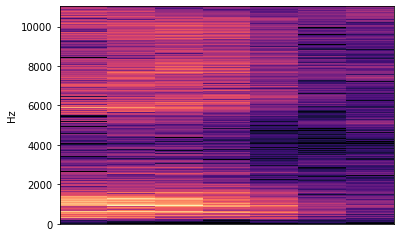

In [ ]:
#@title **code** To compute FFT
import librosa.display as dis
D = librosa.amplitude_to_db(np.abs(librosa.stft(wav)), ref=np.max)
print( D.shape)
print( D.reshape(D.shape[0]*D.shape[1]).shape)
dis.specshow(D, y_axis='linear');

In audio one of the more relevant and compact features is the `melspectrogram` [wiki](https://es.wikipedia.org/wiki/MFCC)

(128, 7)


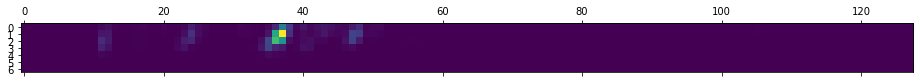

In [ ]:
#@title **code** To compute melspectrogram
SP = librosa.feature.melspectrogram(wav)
print( SP.shape)
plt.matshow(SP.T)

Built a function to recover $\mathbf{X},\mathbf{y}$ but using melspectrogram as descriptor. 

- Do a padding of max = 1000

In [ ]:
#@title **code** To compute X, y
def get_Xy_Features(DATA_DIR = 'data/fsdd/', pad_size=500):
    
    X = []
    y = []

    for fname in os.listdir(DATA_DIR):
        struct = fname.split('_')
        digit = struct[0]
        if (digit is '0') or (digit is '1'):
          wav, sr = librosa.load(DATA_DIR + fname)
          D = librosa.feature.melspectrogram(wav)
          padded = func_padding(D.reshape(D.shape[0]*D.shape[1]), pad_size)
          #print( D.reshape(D.shape[0]*D.shape[1]).shape)
          #print( padded.shape)
          X.append(padded)        
          y.append(digit)
    return np.vstack(X), np.array(y)



In [ ]:
#@title **code** To compute train-test
from sklearn.model_selection import train_test_split
X, y = get_Xy_Features(DATA_DIR = 'data/fsdd/')
print( 'X:', X.shape)
print( 'y:', y.shape)
test_size = 0.1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
print(X_train.shape, y_train.shape)
print(X_train[0].shape)

X: (400, 500)
y: (400,)
(360, 500) (360,)
(500,)


In [ ]:
#@title **code** One-hot encoding
y_train_ohe = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test_ohe = tf.keras.utils.to_categorical(y_test, num_classes=2)
print(y_train_ohe.shape, y_test_ohe.shape)

(360, 2) (40, 2)


<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/ai/ai-2-uis-student/-/raw/master/imgs/icon1.png" width="200">

1. Now train a DNN model: 

  - Using an input of 1000.
  - A hidden layer of 128 neurons
  - A sof max layer of n classes

2. Now train a DNN model: 

  - Using an input of 1000.
  - A hidden layer of 2000 neurons
  - A hidden layer of 1000 neurons
  - A hidden layer of 500 neurons
  - A sof max layer of n classes

In [ ]:
#@title **code** DNN model
model = tf.keras.Sequential([
    tf.keras.layers.Flatten( input_shape= X_train[0].shape),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),                             
    tf.keras.layers.Dense(2, activation=tf.nn.softmax)                    
])



model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 500)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               64128     
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 258       
Total params: 64,386
Trainable params: 64,386
Non-trainable params: 0
_________________________________________________________________


Epoch 1/40
4/4 [==============================] - 1s 116ms/step - loss: 3.0297 - accuracy: 0.5071 - val_loss: 1.7907 - val_accuracy: 0.5750
Epoch 2/40
4/4 [==============================] - 0s 16ms/step - loss: 2.3168 - accuracy: 0.6272 - val_loss: 1.7957 - val_accuracy: 0.5500
Epoch 3/40
4/4 [==============================] - 0s 16ms/step - loss: 1.4437 - accuracy: 0.7516 - val_loss: 1.9413 - val_accuracy: 0.5250
Epoch 4/40
4/4 [==============================] - 0s 17ms/step - loss: 1.2677 - accuracy: 0.7492 - val_loss: 1.4241 - val_accuracy: 0.6250
Epoch 5/40
4/4 [==============================] - 0s 17ms/step - loss: 0.9959 - accuracy: 0.8108 - val_loss: 0.8662 - val_accuracy: 0.7000
Epoch 6/40
4/4 [==============================] - 0s 18ms/step - loss: 0.7457 - accuracy: 0.8758 - val_loss: 0.6552 - val_accuracy: 0.7000
Epoch 7/40
4/4 [==============================] - 0s 18ms/step - loss: 0.5414 - accuracy: 0.8994 - val_loss: 0.4144 - val_accuracy: 0.7500
Epoch 8/40
4/4 [==========

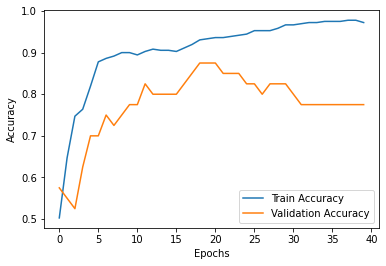

In [ ]:
#@title **code** To compile and fit the model
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train,
          y_train_ohe,
          epochs=40,
          batch_size=100,
          validation_data=(X_test, y_test_ohe))
                           
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [ ]:
#@title **code** To evaluate the model 
test_loss, test_acc = model.evaluate(X_test, y_test_ohe, verbose=False)

print( 'Test accuracy:', test_acc, " test_loss: ", test_loss)

Test accuracy: 0.7749999761581421  test_loss:  0.7416583299636841


<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/ai/ai-2-uis-student/-/raw/master/imgs/icon1.png" width="200">

- In this particular dataset, it is better to perform train-test split according to the actors, that its to say:
    - Three actors for training
    - The other actor for test. 
Built a function that receive a list with three actors for training and the actor for test and return the respectives $( \mathbf{X_{tr}}, \mathbf{X_{te}}, \mathbf{y_{tr}}, \mathbf{y_{te}} )$


In [ ]:
#@title **code student**
DATA_DIR = '../data/fsdd/'
def fun_ByActor(list_train = ['jackson','theo','yweweler'], pad_size=1000):
    




                
    return np.vstack(X_tr),np.vstack(X_te), np.array(y_tr),np.array(y_te) 

In [ ]:
#@title **code student**


X_tr, X_te, y_tr, y_te = fun_ByActor(['jackson','theo','yweweler'], 1000)

In [ ]:
#@title **code student**
print(X_tr.shape, X_te.shape, y_tr.shape, y_te.shape)

Check the previous configuration. 
 - What about the performance?

In [ ]:
#@title **code student**
model = keras.models.Sequential([




])
model.summary()

In [ ]:
#@title **code student**
model.compile(   )

In [ ]:
#@title **code student**
history = model.fit(X_tr,
          y_tr,
          epochs=10,
          batch_size=1000,
          validation_data=(X_te, y_te))

plt.plot(history.history['acc'], label='Train Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [ ]:
#@title **code student**
test_loss, test_acc = model.evaluate(X_te, y_te, verbose=False)

print('Test accuracy:', test_acc, " test_loss: ", test_loss)

---
<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/ai/ai-uis-student/raw/master/imgs/bannerThanks.jpg" alt="Drawing" style="width:700px;"/>
